<a href="https://colab.research.google.com/github/BC-Chang/porescale_permeability_2d/blob/master/Permeability_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Permeability Estimation
### Drs. Masa Prodanovic and Bernard Chang


In this activity, we will compute the single phase permeability of a 2D sample using lattice Boltzmann (LBM) simulations.

Before we get started, let's import some packages.

In [1]:
#@title Import Packages
%%capture
!pip install scikit-image==0.23.2 "numpy<2.0.0" porespy==2.2.2 --force-reinstall

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import tifffile
import porespy as ps

from skimage.measure import regionprops,label

import sys
import os
from tqdm import tqdm

try:
  os.chdir("./porescale_permeability_2d")
  # sys.path.append("./LBM_Workshop/")
except:
  !git clone https://github.com/BC-Chang/porescale_permeability_2d.git
  os.chdir("./porescale_permeability_2d")

from plotting_utils import plot_profile, plot_quiver, plot_streamlines

# Import a timer
from time import perf_counter_ns, sleep

# Import ipywidgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display, clear_output

import torch


ERROR:openpnm:PARDISO solver not installed, run `pip install pypardiso`. Otherwise, simulations will be slow. Apple M chips not supported.


## Defining the lattice Boltzmann method

On a basic level, LBM is a common simulation method for modeling how fluids move by tracking groups of particles on a grid. Instead of solving complex equations (Navier-Stokes) directly, LBM follows simple rules for how these particles collide and flow. We can then visualize and calculate a value for permeability the simulation results.

If you are interested in specifics, see the [D2Q9_LBM_main.ipynb notebook](https://github.com/BC-Chang/porescale_permeability_2d/blob/master/D2Q9_LBM_main.ipynb).

### Define lattice and discrete velocities

In [2]:
def initialize_weights():

  # Define lattice velocity vectors
  ex = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1], dtype=np.double)
  ey = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1], dtype=np.double)


  # Define weights
  w_i = np.array([4./9.,
                  1./9.,
                  1./9.,
                  1./9.,
                  1./9.,
                  1./36.,
                  1./36.,
                  1./36.,
                  1./36.], dtype=np.double)

  return ex, ey, w_i

### Obtaining Macroscopic Properties

The following function computes some macroscopic density and momentum from the particle distributions.


In [3]:
def macroscopic(f, fx, fy, ex, ey, nx, ny):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Initialize outputs to 0s
  u_x = torch.zeros((nx, ny), dtype=torch.float64).to(device)
  u_y = torch.zeros((nx, ny), dtype=torch.float64).to(device)
  rho = torch.zeros((nx, ny), dtype=torch.float64).to(device)

  # Calculate macroscopic properties from moments. Only calculate where there are fluid nodes
  # Density
  rho[fx, fy] += torch.sum(f[:, fx, fy], axis=0)

  # Velocity
  u_x[fx, fy] += torch.sum(ex[:, None] * f[:, fx, fy], axis=0)
  u_y[fx, fy] += torch.sum(ey[:, None] * f[:, fx, fy], axis=0)
  u_x[fx, fy] = u_x[fx, fy] / rho[fx, fy]
  u_y[fx, fy] = u_y[fx, fy] / rho[fx, fy]

  return rho, u_x, u_y


### Equilibrium Calculation


In [4]:
def equilibrium(rho, ux, uy, ex, ey, w_i, nx, ny, fx, fy, tau, g):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Extract only fluid nodes and add forcing to velocity
  ux = ux[fx, fy] + tau*g
  uy = uy[fx, fy]

  feq = torch.zeros((9, nx, ny), dtype=torch.float64).to(device)

  for i in range(9):
    # Compute 2nd term in parenthesis of feq equation above
    uc = ex[i]*ux + ey[i]*uy
    feq[i, fx, fy] = rho[fx, fy] * w_i[i] * (1 + 3*uc + (9./2.)*uc**2 - (3./2.)*(ux**2 + uy**2))

  return feq

### Collision Step

In [5]:
def collision(f, feq, tau, sx, sy, fx, fy):
    # Standard Bounceback for Solid Nodes
    # Left-Right
    f[1, sx, sy], f[3, sx, sy] = f[3, sx, sy], f[1, sx, sy]

    # Up-Down
    f[2, sx, sy], f[4, sx, sy] = f[4, sx, sy], f[2, sx, sy]

    # Top Right - Bottom Left
    f[5, sx, sy], f[7, sx, sy] = f[7, sx, sy], f[5, sx, sy]

    # Top Left - Bottom Right
    f[6, sx, sy], f[8, sx, sy]  = f[8, sx, sy], f[6, sx, sy]

    # Regular collision in fluid nodes
    f[:, fx, fy] -= (f[:, fx, fy] - feq[:, fx, fy]) / tau

    return f

### Putting it all together

Putting the above functions into a time loop will give us our first simulator!

Our first example will be simulating the flow around a cylinder, known as the Karman vortex street — considered a "Hello, World!" of LBM simulations.

In [6]:
def run_lbm(data):

    # Initialization
    tau = 1.0  # Relaxation time
    g = 0.00001  # Gravity or other force
    density = 1.
    tf = 10001  # Maximum number of iteration steps
    precision = 1.E-5  # Convergence criterion
    vold = 1000
    eps = 1E-6

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = torch.tensor(data).to(device)
    check_convergence = 30  # Check convergence every [check_convergence] time steps

    # Define lattice velocity vectors
    ex, ey, w_i = initialize_weights()
    ex = torch.tensor(ex).to(device)
    ey = torch.tensor(ey).to(device)
    w_i = torch.tensor(w_i).to(device)

    # Indices of fluid nodes
    fluid_id = torch.argwhere(data == 0).to(device)
    fx = fluid_id[:, 0]
    fy = fluid_id[:, 1]

    # Indices of solid nodes
    solid_id = torch.argwhere(data == 1).to(device)
    sx = solid_id[:, 0]
    sy = solid_id[:, 1]

    # Solid nodes are labeled 1, fluid nodes are labeled 0
    is_solid_node = data

    nx, ny = data.shape

    # Initialize distribution functions
    f = w_i * density
    # Broadcast to 3D array with each slice corresponding to a direction's weights
    f = torch.tile(f[:, None, None], (nx, ny)).type(torch.float64).to(device)

    # Allocate memory to equilibrium functions
    feq = torch.empty_like(f, dtype=torch.float64).to(device)

    # Each point has x-component ex, and y-component ey
    u_x = torch.empty((nx, ny), dtype=torch.float64).to(device)
    u_y = torch.empty((nx, ny), dtype=torch.float64).to(device)

    # Node density
    rho = torch.zeros((nx, ny), dtype=torch.float64)

    # # Begin time loop
    tic = perf_counter_ns()
    for ts in tqdm(range(tf)):
        # print(f"{ts = }")  # Print timestep

        # Compute macroscopic density, rho and velocity.
        rho, u_x, u_y = macroscopic(f, fx, fy, ex, ey, nx, ny)

        # Add forcing to velocity and compute equilibrium function
        feq = equilibrium(rho, u_x, u_y, ex, ey, w_i, nx, ny, fx, fy, tau, g)

        # Collision Step
        f = collision(f, feq, tau, sx, sy, fx, fy)

        # Streaming Step
        f[1] = torch.roll(f[1], 1, dims=1)
        f[2] = torch.roll(f[2], 1, dims=0)
        f[3] = torch.roll(f[3], -1, dims=1)
        f[4] = torch.roll(f[4], -1, dims=0)

        f[5] = torch.roll(f[5], (1, 1), dims=(0,1))
        f[6] = torch.roll(f[6], (-1, 1), dims=(1,0))
        f[7] = torch.roll(f[7], (-1, -1), dims=(0,1))
        f[8] = torch.roll(f[8], (1, -1), dims=(1,0))

        # Calculate velocity
        u = torch.sqrt(u_x**2 + u_y**2)

        # Check convergence every check_convergence time step
        if ts % check_convergence == 0:

            vnew = torch.mean(u)
            error = torch.abs(vold - vnew) / (vold+eps)
            vold = vnew

            if error < precision:
                print(f'Simulation has converged in {ts} time steps')
                break

        if ts == tf:
            print('Reached maximum iterations')

    toc = perf_counter_ns()
    print(f"Elapsed Time: {(toc - tic)*1E-9}s")

    u_x = u_x.to('cpu')
    u_y = u_y.to('cpu')
    u = u.to('cpu')

    return u_x, u_y, u

###  Read in the geometry
Before we get into the flow simulation, let's first read in our geometry. For this exercise, we assume a 2D binary image with:
- 0 indicating fluid space
- 1 indicating solid space

For this workshop, we select an image from the data folder. You can also load in your own image or create one yourself if you'd like.


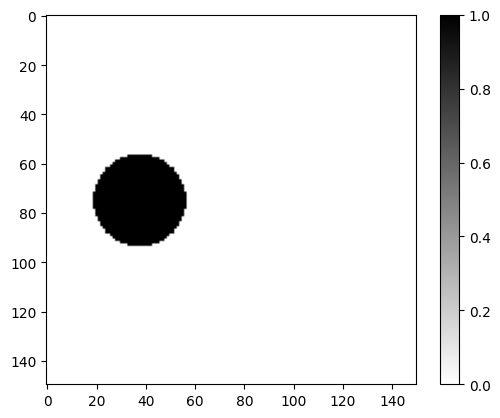

In [7]:
Nx = 150
Ny = 150
X, Y = np.meshgrid(range(Nx), range(Ny))
data = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/8)**2

plt.imshow(data, cmap='binary')
plt.colorbar()


Let's run our LBM simulation! This simulation does not fully converge in the default number of iterations, but it gets the point across. This should take about one minute to run.

In [8]:
u_x, u_y, u = run_lbm(data)

100%|██████████| 10001/10001 [00:41<00:00, 239.87it/s]

Elapsed Time: 41.697465307s


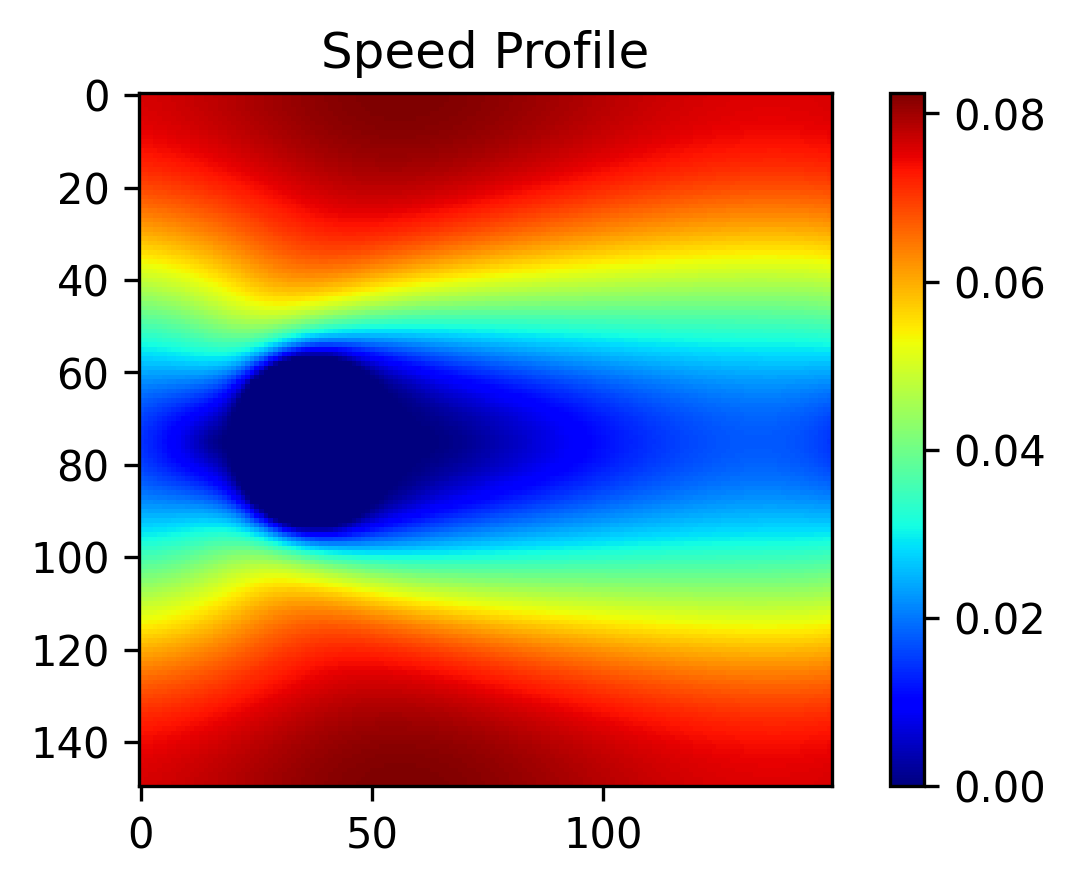

In [9]:
_ = plot_profile(u, cmap='jet')

In [10]:
#@title Read in data
geom_options = os.listdir("./data/")

# TODO create catalog of images, read in from drop down, and plot.
data_dropdown = widgets.Dropdown(
    concise=False,
    options=geom_options,
    value='beads.tif',
    description='Select a file to read in'
)

# select_button = widgets.Button(description='I want this one!')
# output = widgets.Output()
def read_in_and_plot(dropdown):
  display(dropdown)
  data = tifffile.imread(os.path.join("./data/", dropdown))
  clear_output(wait=True)
  display(dropdown)
  plt.imshow(data, cmap='binary')
  plt.colorbar()
  plt.show()

  return data

widget = widgets.interactive(read_in_and_plot, dropdown=geom_options)
display(widget)


interactive(children=(Dropdown(description='dropdown', options=('bevo.tif', 'beads.tif', 'micromodel.tif'), va…

In [11]:
data = widget.result
u_x, u_y, u = run_lbm(data)


 91%|█████████ | 9060/10001 [00:31<00:03, 285.64it/s]

Simulation has converged in 9060 time steps
Elapsed Time: 31.720625721s


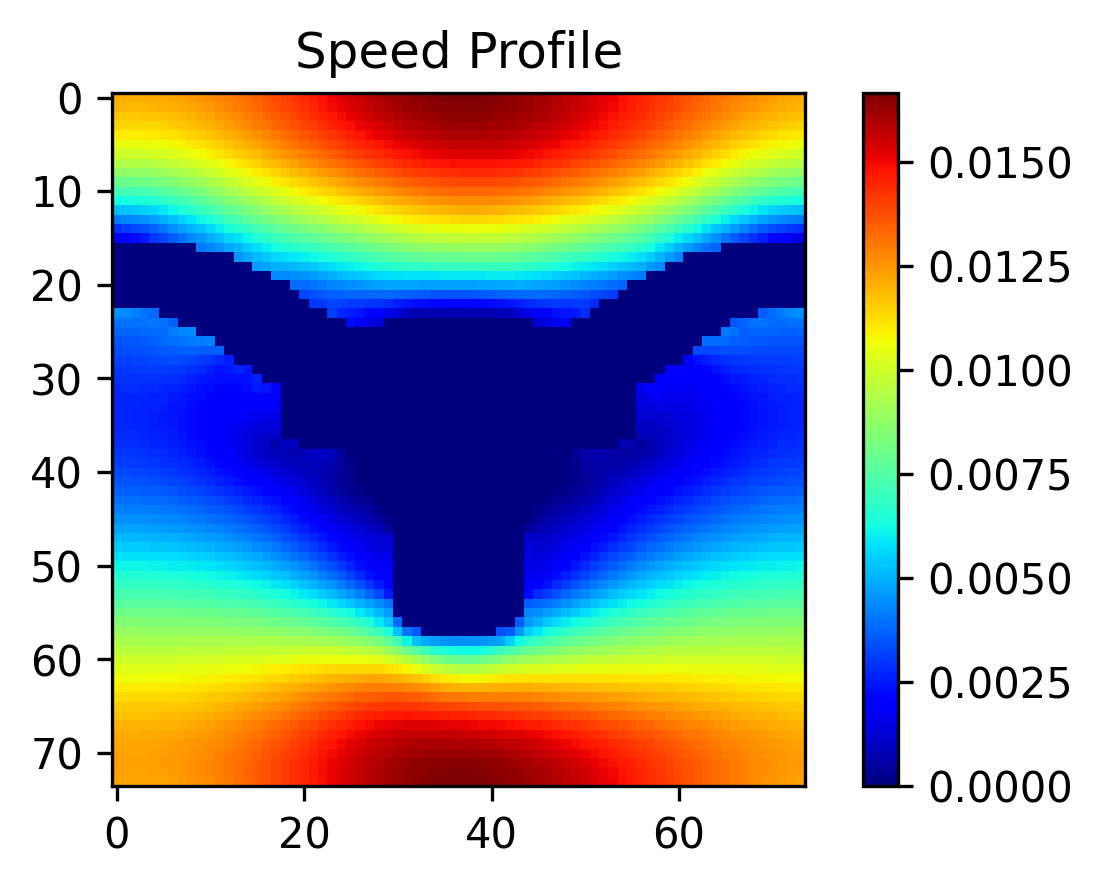

In [12]:
# from plotting_utils import plot_quiver
profile_fig = plot_profile(u, cmap='jet')

## Calculate Permeability

Once we have the velocity field, we can compute the absolute permeability using Darcy's law:

$$k = \frac{\bar{u} \mu L}{\Delta P}$$

Since we used a force to drive flow (instead of pressure), we can equivalently compute permeability as

$$k = \frac{\bar{u} \mu}{F}$$


Keep in mind that the calculated permeability will be in lattice units ($lu^2$). To convert to the true permeability, we would need to know the physical size of our grid.


In [18]:
def permeability(ux, tau=1.0, F=0.00001):
  u_mean = torch.mean(ux[ux != 0])
  print(f"Average Velocity = {u_mean} lu/ts")

  mu = (tau - 0.5) / 3
  permeability = u_mean * mu / F

  print(f"Permeability = {permeability} lu^2")
  return

# Calculate the average velocity for our image
permeability(u_x)

Average Velocity = 0.008090107869257757 lu/ts
Permeability = 134.83513115429594 lu^2


## Porosimetry

Porosimetry is a method used to measure the numbers and sizes of pores. It helps us understand how easily fluids (or small beads) can pass through the material.

In [2]:
#@title Read in data
geom_options = os.listdir("./data/")

# TODO create catalog of images, read in from drop down, and plot.
data_dropdown = widgets.Dropdown(
    concise=False,
    options=geom_options,
    value='beads.tif',
    description='Select a file to read in'
)

# select_button = widgets.Button(description='I want this one!')
# output = widgets.Output()
def read_in_and_plot(dropdown):
  display(dropdown)
  data = tifffile.imread(os.path.join("./data/", dropdown))
  clear_output(wait=True)
  display(dropdown)
  plt.imshow(data, cmap='binary')
  plt.colorbar()
  plt.show()

  return data

widget = widgets.interactive(read_in_and_plot, dropdown=geom_options)
display(widget)

interactive(children=(Dropdown(description='dropdown', options=('bevo.tif', 'beads.tif', 'micromodel.tif'), va…

### Traditional Drainage Curve

In the following cell we will run a porosimetry simulation and plot the *drainage curve*.

We want to measure how *capillary pressure*, which is inversely related to pore radius, varies with *saturation* (how much of one fluid is present versus the other). In other words, we are measuring how much pressure must be applied to push a certain amount of fluid into the porous material.

**The key idea:**

To push more fluid into the sample (i.e., to increase saturation), we need to overcome capillary forces in progressively smaller pores — which means applying higher pressure.


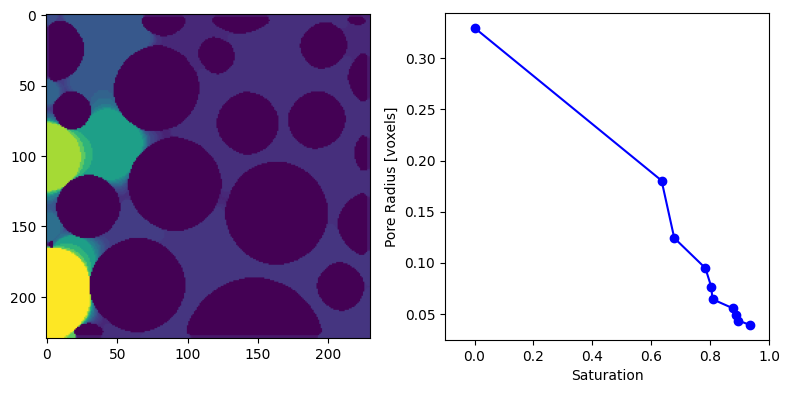

In [71]:
data = widget.result
# Invert the data. Pores should be labeled 1, solids 0
data = ~(data.astype(bool))
# Define inlet
inlet = np.zeros_like(data)
# Inlet is on the left boundary of the image
inlet[:, 0] = True

# Run porosimetry from PoreSpy
mip = ps.filters.porosimetry(im=data, inlets=inlet)
pore_radii = ps.metrics.pore_size_distribution(mip, log=False)
saturation = 1 - pore_radii.cdf

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].imshow(mip)
ax[1].plot(saturation, 1/pore_radii.R, 'bo-')
ax[1].set_xlabel('Saturation');
ax[1].set_ylabel('Pore Radius [voxels]')
ax[1].set_xlim([-0.10, 1])

plt.tight_layout()

**Another way to think about this:**

Imagine rolling a ball of radius $r$ into the porous medium. The ball can only enter regions where the pores are large enough to fit it. As we decrease the radius of the ball, it can reach deeper into the structure. This is similar to how increasing capillary pressure allows fluid to invade smaller pores.

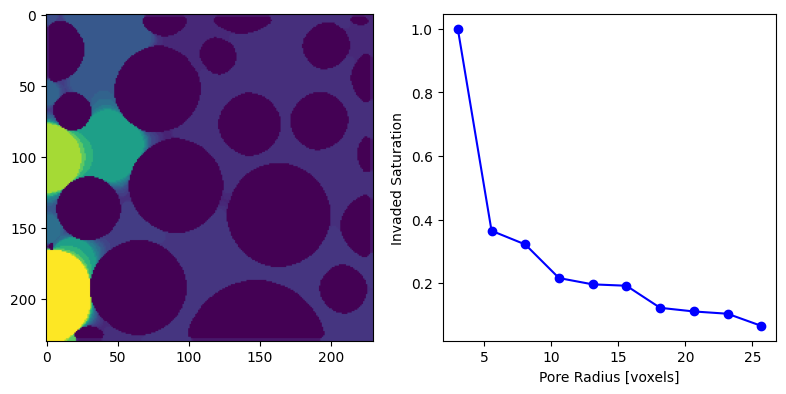

In [75]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].imshow(mip)
ax[1].plot(pore_radii.R, 1-saturation, 'bo-')
ax[1].set_ylabel('Invaded Saturation');
ax[1].set_xlabel('Pore Radius [voxels]')

plt.tight_layout()